# 🎯 Model 1: Persona Classification

## 5 Persona yang akan diprediksi:

1. **The Sprinter** - Fast learner, nilai tinggi
2. **The Deep Diver** - Lambat tapi teliti, nilai tinggi
3. **The Night Owl** - Belajar malam hari
4. **The Struggler** - Butuh bantuan ekstra
5. **The Consistent** - Belajar rutin dan teratur

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [2]:
# Load data
df = pd.read_csv('../data/processed/clustering_features.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns:\n{df.columns.tolist()}")
df.head()

Dataset shape: (2008, 23)

Columns:
['developer_id', 'journey_id', 'name', 'avg_study_hour', 'study_consistency_std', 'study_consistency_ratio', 'completed_modules', 'total_modules_viewed', 'avg_exam_score', 'exam_pass_rate', 'exam_fail_count', 'avg_submission_rating', 'submission_pass_rate', 'submission_fail_count', 'submission_fail_rate', 'completion_speed', 'retry_count', 'performance_score', 'struggle_score', 'study_time_slot', 'performance_level', 'speed_category', 'difficulty']


,developer_id,journey_id,name,avg_study_hour,study_consistency_std,study_consistency_ratio,completed_modules,total_modules_viewed,avg_exam_score,exam_pass_rate,...,submission_fail_count,submission_fail_rate,completion_speed,retry_count,performance_score,struggle_score,study_time_slot,performance_level,speed_category,difficulty
0,3390,14,Belajar Fundamental Aplikasi Android,14.264550,69.602385,0.028134,104,189,62.500000,0.75,...,10.0,1.0,0.521429,1.0,46.6,22.0,Afternoon (12-18),Medium,Fast (< 70%),2.0
1,3390,32,Belajar Membangun LINE Chatbot,13.366667,439.000000,0.003390,0,30,83.846154,0.00,...,0.0,0.0,0.560000,0.0,0.0,0.0,Afternoon (12-18),Low,Fast (< 70%),1.0
2,3390,47,Menjadi Game Developer Expert,12.824000,113.395442,0.035026,0,125,83.846154,0.00,...,4.0,1.0,0.578571,1.0,27.0,8.0,Afternoon (12-18),Low,Fast (< 70%),2.0
3,3390,51,Belajar Membuat Aplikasi Android untuk Pemula,15.558824,582.693955,0.003610,30,34,65.000000,0.40,...,0.0,0.0,0.560000,0.0,26.0,6.0,Afternoon (12-18),Low,Fast (< 70%),1.0
4,3390,55,Kotlin Android Developer Expert,13.517241,140.264250,0.010728,5,58,83.846154,0.00,...,6.0,1.0,0.600000,1.0,34.0,12.0,Afternoon (12-18),Low,Fast (< 70%),2.0


In [3]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   developer_id             2008 non-null   int64  
 1   journey_id               2008 non-null   int64  
 2   name                     2008 non-null   object 
 3   avg_study_hour           2008 non-null   float64
 4   study_consistency_std    2008 non-null   float64
 5   study_consistency_ratio  2008 non-null   float64
 6   completed_modules        2008 non-null   int64  
 7   total_modules_viewed     2008 non-null   int64  
 8   avg_exam_score           2008 non-null   float64
 9   exam_pass_rate           2008 non-null   float64
 10  exam_fail_count          2008 non-null   float64
 11  avg_submission_rating    2008 non-null   float64
 12  submission_pass_rate     2008 non-null   float64
 13  submission_fail_count    2008 non-null   float64
 14  submission_fail_rate    

In [4]:
# Check statistics of key features
key_features = ['avg_study_hour', 'study_consistency_std', 'completion_speed', 
                'avg_exam_score', 'submission_fail_rate', 'retry_count']

df[key_features].describe()

,avg_study_hour,study_consistency_std,completion_speed,avg_exam_score,submission_fail_rate,retry_count
count,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000
mean,13.815199,63.583960,1.076897,81.635622,0.273406,0.637948
std,3.901394,102.130422,1.932933,12.886300,0.445819,0.776392
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.474080,0.000000,0.533333,79.294201,0.000000,0.000000
50%,13.919643,5.857738,0.560000,83.846154,0.000000,1.000000
75%,16.387234,97.251981,0.590217,88.571429,1.000000,1.000000
max,23.000000,761.817709,10.000000,100.000000,1.000000,9.000000


## 2. Generate Labels menggunakan Rule-Based

### Kriteria Persona:

| Persona | Kriteria | Priority |
|---------|----------|----------|
| The Night Owl | avg_study_hour >= 19 | 1 |
| The Struggler | avg_exam_score < 60 AND submission_fail_rate > 0.3 | 2 |
| The Sprinter | completion_speed < 0.5 AND avg_exam_score >= 75 | 3 |
| The Deep Diver | completion_speed > 2.0 AND avg_exam_score >= 70 | 4 |
| The Consistent | Default (study_consistency_std rendah) | 5 |

In [5]:
def assign_persona(row):
    """
    Assign persona label berdasarkan kriteria bisnis.
    Priority order untuk menghindari overlap.
    """
    avg_study_hour = row['avg_study_hour']
    study_consistency_std = row.get('study_consistency_std', 100)
    completion_speed = row['completion_speed']
    avg_exam_score = row['avg_exam_score']
    submission_fail_rate = row['submission_fail_rate']
    retry_count = row.get('retry_count', 0)
    
    # Priority 1: Night Owl (jam belajar malam >= 19)
    if avg_study_hour >= 19:
        return 'The Night Owl'
    
    # Priority 2: Struggler (nilai rendah + banyak gagal)
    if avg_exam_score < 60 and submission_fail_rate > 0.3:
        return 'The Struggler'
    
    # Priority 3: Sprinter (cepat + nilai tinggi)
    if completion_speed < 0.5 and avg_exam_score >= 75:
        return 'The Sprinter'
    
    # Priority 4: Deep Diver (lambat + nilai tinggi)
    if completion_speed > 2.0 and avg_exam_score >= 70:
        return 'The Deep Diver'
    
    # Priority 5: Consistent (default - konsistensi tinggi)
    return 'The Consistent'

# Apply labeling
df['persona_label'] = df.apply(assign_persona, axis=1)

# Check distribution
print("Persona Distribution:")
print(df['persona_label'].value_counts())
print(f"\nPercentages:")
print(df['persona_label'].value_counts(normalize=True) * 100)

Persona Distribution:
persona_label
The Consistent    1262
The Sprinter       358
The Night Owl      202
The Deep Diver     157
The Struggler       29
Name: count, dtype: int64

Percentages:
persona_label
The Consistent    62.848606
The Sprinter      17.828685
The Night Owl     10.059761
The Deep Diver     7.818725
The Struggler      1.444223
Name: proportion, dtype: float64


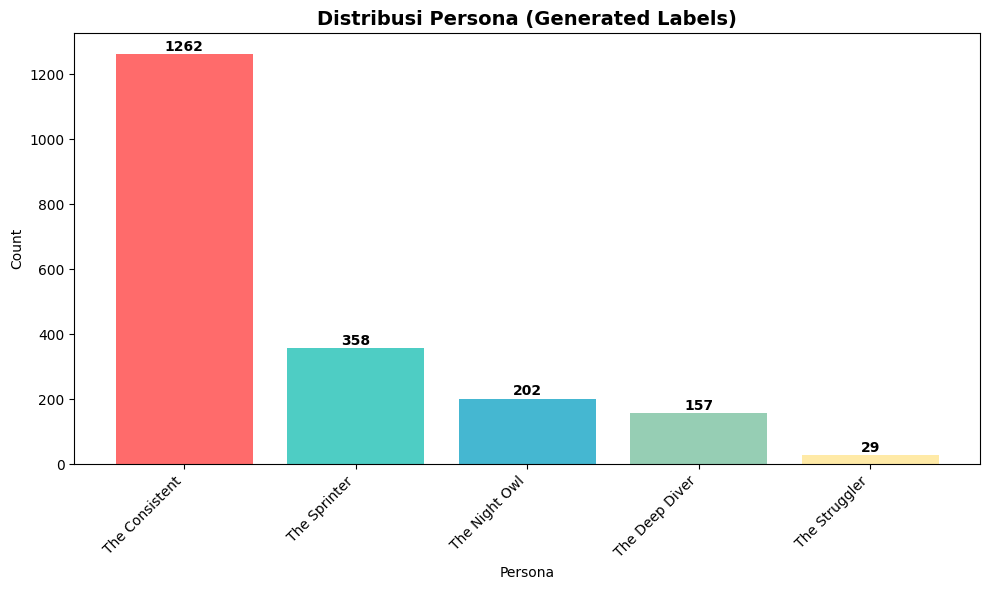

In [6]:
# Visualize distribution
plt.figure(figsize=(10, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
persona_counts = df['persona_label'].value_counts()

plt.bar(persona_counts.index, persona_counts.values, color=colors)
plt.title('Distribusi Persona (Generated Labels)', fontsize=14, fontweight='bold')
plt.xlabel('Persona')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add count labels
for i, v in enumerate(persona_counts.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
# plt.savefig('../reports/figures/persona_distribution_classification.png', dpi=150)
plt.show()

## 3. Prepare Features for Classification

In [7]:
# Define features for classification
FEATURE_COLUMNS = [
    'avg_study_hour',
    'study_consistency_std', 
    'completion_speed',
    'avg_exam_score',
    'submission_fail_rate',
    'retry_count'
]

# Prepare X and y
X = df[FEATURE_COLUMNS].copy()
y = df['persona_label'].copy()

# Handle missing values
X = X.fillna(X.median())

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature statistics:")
X.describe()

Features shape: (2008, 6)
Target shape: (2008,)

Feature statistics:


,avg_study_hour,study_consistency_std,completion_speed,avg_exam_score,submission_fail_rate,retry_count
count,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000
mean,13.815199,63.583960,1.076897,81.635622,0.273406,0.637948
std,3.901394,102.130422,1.932933,12.886300,0.445819,0.776392
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.474080,0.000000,0.533333,79.294201,0.000000,0.000000
50%,13.919643,5.857738,0.560000,83.846154,0.000000,1.000000
75%,16.387234,97.251981,0.590217,88.571429,1.000000,1.000000
max,23.000000,761.817709,10.000000,100.000000,1.000000,9.000000


In [8]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")

Label mapping:
  0: The Consistent
  1: The Deep Diver
  2: The Night Owl
  3: The Sprinter
  4: The Struggler


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded  # Maintain class distribution
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1606 samples
Test set: 402 samples


In [10]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")

Features scaled successfully!


## 4. Train Classification Model

In [11]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

# Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Random Forest Results:")
print(f"  Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Random Forest Results:
  Training Accuracy: 0.9988 (99.88%)
  Test Accuracy: 0.9801 (98.01%)


In [12]:
# Cross-validation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


Cross-Validation Scores: [0.99378882 0.99065421 0.99065421 0.98753894 0.99376947]
Mean CV Score: 0.9913 (+/- 0.0047)


In [13]:
# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))


CLASSIFICATION REPORT
                precision    recall  f1-score   support

The Consistent       0.98      1.00      0.99       253
The Deep Diver       0.97      0.97      0.97        31
 The Night Owl       0.98      1.00      0.99        40
  The Sprinter       1.00      1.00      1.00        72
 The Struggler       0.00      0.00      0.00         6

      accuracy                           0.98       402
     macro avg       0.78      0.79      0.79       402
  weighted avg       0.97      0.98      0.97       402



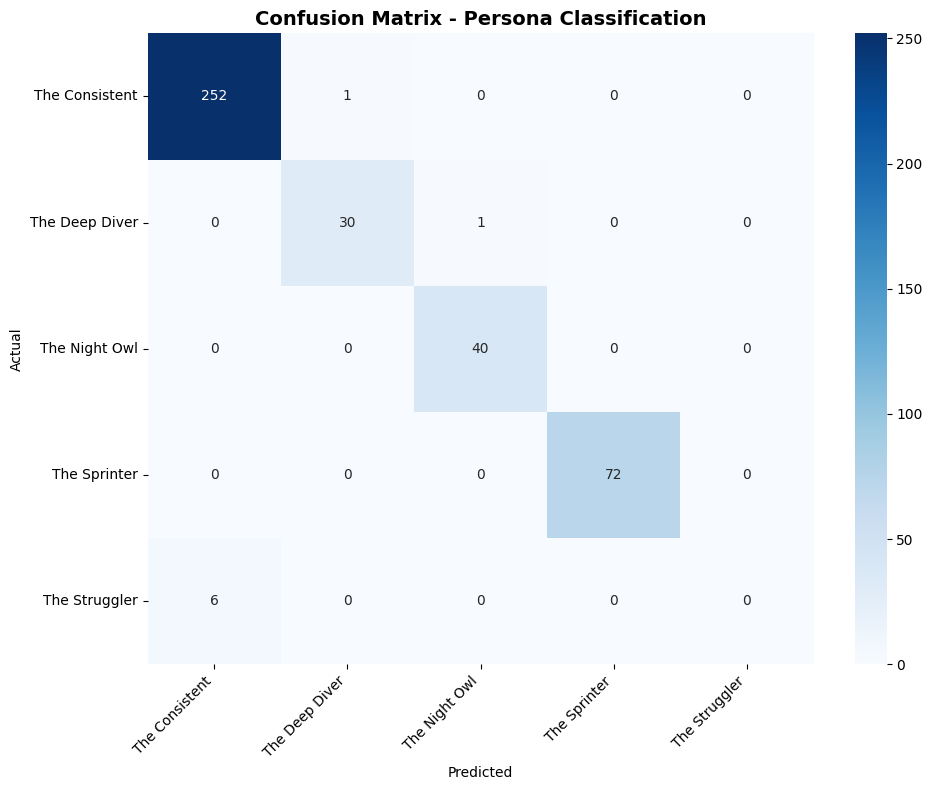

In [14]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Persona Classification', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# plt.savefig('../reports/figures/confusion_matrix_classification.png', dpi=150)
plt.show()

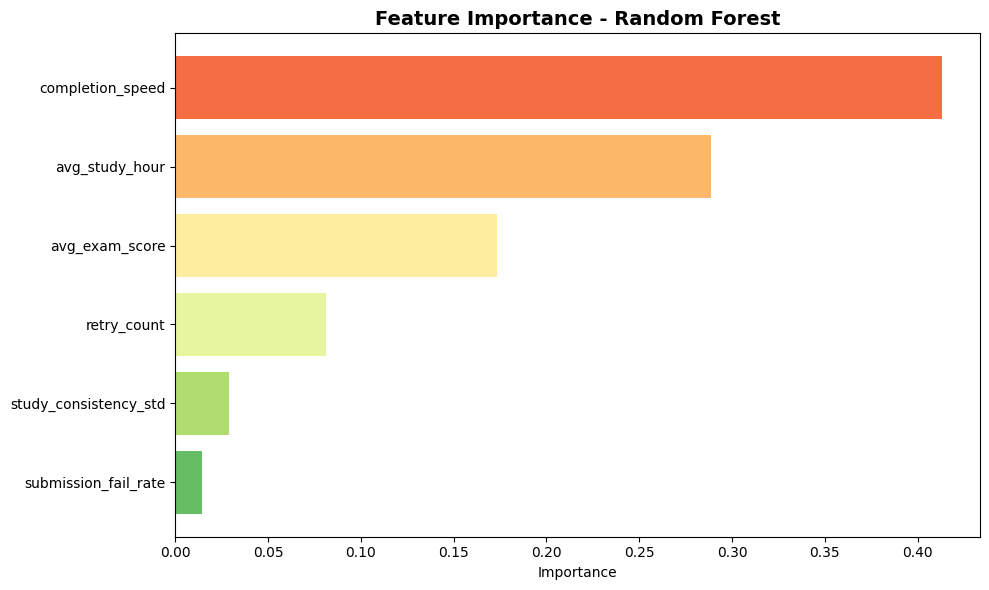


Feature Importance:
                 feature  importance
2       completion_speed    0.412974
0         avg_study_hour    0.288776
3         avg_exam_score    0.173457
5            retry_count    0.081361
1  study_consistency_std    0.028958
4   submission_fail_rate    0.014475


In [15]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_importance)))
plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig('../reports/figures/feature_importance_classification.png', dpi=150)
plt.show()

print("\nFeature Importance:")
print(feature_importance)

## 5. Test with Specific Cases

In [16]:
# Test cases yang sebelumnya GAGAL di clustering
test_cases = [
    {
        "name": "High Performer (score=95.67, fail=0) - seharusnya BUKAN Struggler",
        "data": [14.0, 100.0, 0.5, 95.67, 0.0, 0],
        "expected": "The Consistent"
    },
    {
        "name": "Night Owl (jam 21)",
        "data": [21.0, 50.0, 1.0, 80.0, 0.1, 0],
        "expected": "The Night Owl"
    },
    {
        "name": "Struggler (score=45, fail=0.5)",
        "data": [12.0, 150.0, 1.5, 45.0, 0.5, 3],
        "expected": "The Struggler"
    },
    {
        "name": "Sprinter (speed=0.3, score=88)",
        "data": [14.0, 80.0, 0.3, 88.0, 0.05, 0],
        "expected": "The Sprinter"
    },
    {
        "name": "Deep Diver (speed=3.0, score=85)",
        "data": [15.0, 60.0, 3.0, 85.0, 0.1, 1],
        "expected": "The Deep Diver"
    }
]

print("="*70)
print("TEST CASES - Classification Model")
print("="*70)

correct = 0
total = len(test_cases)

for test in test_cases:
    X_test_case = pd.DataFrame([test['data']], columns=FEATURE_COLUMNS)
    X_test_scaled = scaler.transform(X_test_case)
    
    # Predict
    pred_encoded = rf_model.predict(X_test_scaled)[0]
    pred_proba = rf_model.predict_proba(X_test_scaled)[0]
    predicted = label_encoder.inverse_transform([pred_encoded])[0]
    confidence = pred_proba[pred_encoded]
    
    is_correct = predicted == test['expected']
    if is_correct:
        correct += 1
    
    status = "[OK]" if is_correct else "[WRONG]"
    
    print(f"\n{test['name']}:")
    print(f"  Expected: {test['expected']}")
    print(f"  Predicted: {predicted}")
    print(f"  Confidence: {confidence:.2%}")
    print(f"  Status: {status}")

print("\n" + "="*70)
print(f"RESULT: {correct}/{total} correct ({correct/total*100:.1f}%)")
print("="*70)

TEST CASES - Classification Model

High Performer (score=95.67, fail=0) - seharusnya BUKAN Struggler:
  Expected: The Consistent
  Predicted: The Consistent
  Confidence: 94.91%
  Status: [OK]

Night Owl (jam 21):
  Expected: The Night Owl
  Predicted: The Night Owl
  Confidence: 95.14%
  Status: [OK]

Struggler (score=45, fail=0.5):
  Expected: The Struggler
  Predicted: The Consistent
  Confidence: 88.12%
  Status: [WRONG]

Sprinter (speed=0.3, score=88):
  Expected: The Sprinter
  Predicted: The Sprinter
  Confidence: 54.61%
  Status: [OK]

Deep Diver (speed=3.0, score=85):
  Expected: The Deep Diver
  Predicted: The Deep Diver
  Confidence: 81.94%
  Status: [OK]

RESULT: 4/5 correct (80.0%)


## 6. Save Model for Production

In [17]:
# Create persona mapping
persona_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print("Persona Mapping:")
for k, v in persona_mapping.items():
    print(f"  {k}: {v}")

Persona Mapping:
  0: The Consistent
  1: The Deep Diver
  2: The Night Owl
  3: The Sprinter
  4: The Struggler


In [18]:
# Save model as dictionary
model_package = {
    'model': rf_model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'persona_mapping': persona_mapping,
    'feature_columns': FEATURE_COLUMNS,
    'model_type': 'classification',
    'model_metadata': {
        'algorithm': 'RandomForestClassifier',
        'n_estimators': 100,
        'training_accuracy': train_acc,
        'test_accuracy': test_acc,
        'cv_score_mean': cv_scores.mean(),
        'cv_score_std': cv_scores.std(),
        'n_classes': len(persona_mapping),
        'training_samples': len(X_train)
    }
}

# Save model
model_path = '../models/persona_classifier.pkl'
joblib.dump(model_package, model_path)
print(f"Model saved to: {model_path}")

# Verify
loaded = joblib.load(model_path)
print(f"\nVerification - Keys: {list(loaded.keys())}")
print(f"Model type: {loaded['model_type']}")
print(f"Metadata: {loaded['model_metadata']}")

Model saved to: ../models/persona_classifier.pkl

Verification - Keys: ['model', 'scaler', 'label_encoder', 'persona_mapping', 'feature_columns', 'model_type', 'model_metadata']
Model type: classification
Metadata: {'algorithm': 'RandomForestClassifier', 'n_estimators': 100, 'training_accuracy': 0.9987546699875467, 'test_accuracy': 0.9800995024875622, 'cv_score_mean': np.float64(0.9912811284611365), 'cv_score_std': np.float64(0.0023353969600907335), 'n_classes': 5, 'training_samples': 1606}


## 7. Create Inference Function

In [19]:
def predict_persona(user_features: dict, model_package: dict) -> dict:
    """
    Predict persona untuk user berdasarkan fitur.
    
    Args:
        user_features: dict dengan keys:
            - avg_study_hour
            - study_consistency_std
            - completion_speed
            - avg_exam_score
            - submission_fail_rate
            - retry_count
        model_package: dict berisi model, scaler, dll
    
    Returns:
        dict dengan persona_label, confidence, probabilities
    """
    # Extract components
    model = model_package['model']
    scaler = model_package['scaler']
    label_encoder = model_package['label_encoder']
    feature_columns = model_package['feature_columns']
    
    # Prepare features
    features = [user_features.get(col, 0) for col in feature_columns]
    X = pd.DataFrame([features], columns=feature_columns)
    
    # Scale
    X_scaled = scaler.transform(X)
    
    # Predict
    pred_encoded = model.predict(X_scaled)[0]
    pred_proba = model.predict_proba(X_scaled)[0]
    
    # Get persona label
    persona_label = label_encoder.inverse_transform([pred_encoded])[0]
    confidence = pred_proba[pred_encoded]
    
    # All probabilities
    all_probs = {label: prob for label, prob in zip(label_encoder.classes_, pred_proba)}
    
    return {
        'persona_label': persona_label,
        'confidence': round(float(confidence), 4),
        'probabilities': all_probs
    }

# Test inference function
test_user = {
    'avg_study_hour': 21.0,
    'study_consistency_std': 50.0,
    'completion_speed': 1.0,
    'avg_exam_score': 80.0,
    'submission_fail_rate': 0.1,
    'retry_count': 0
}

result = predict_persona(test_user, model_package)
print("Test Inference:")
print(f"  Input: avg_study_hour=21 (Night Owl candidate)")
print(f"  Predicted: {result['persona_label']}")
print(f"  Confidence: {result['confidence']:.2%}")
print(f"  All Probabilities: {result['probabilities']}")

Test Inference:
  Input: avg_study_hour=21 (Night Owl candidate)
  Predicted: The Night Owl
  Confidence: 95.14%
  All Probabilities: {'The Consistent': np.float64(0.04857142857142858), 'The Deep Diver': np.float64(0.0), 'The Night Owl': np.float64(0.9514285714285714), 'The Sprinter': np.float64(0.0), 'The Struggler': np.float64(0.0)}
